# Pokemon Dataset



In [ ]:
!pip install pySankey

In [ ]:
# importing libraries
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable

from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.sankey import Sankey
from pySankey.sankey import sankey


In [ ]:
# Reading the Pokemon csv file
df = pd.read_csv('Pokemon.csv')

In [ ]:
# Validating the csv
df

,SN,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,True


# Data Cleaning

In [ ]:
# Checkiing for any missing value || null values
df.isnull().sum()

,0
SN,0
Name,0
Type 1,0
Type 2,386
HP,0
Attack,0
Defense,0
Sp. Attack,0
Sp. Defense,0
Speed,0


In [ ]:
# Handling NaN - missing values in Types 2
df.fillna({'Type 2' : 'Unknown'}, inplace = True)

In [ ]:
# Validating that the NaN have been handled corretcly
df.isnull().sum()

,0
SN,0
Name,0
Type 1,0
Type 2,0
HP,0
Attack,0
Defense,0
Sp. Attack,0
Sp. Defense,0
Speed,0


In [ ]:
'''
Conduct Descriptive Analysis on Numeric Columns
Getting summary statistics on numeric columns to understand the data's range, mean, and distribution.
'''
df.describe()

,SN,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [ ]:
df.info() #To get the data types of the data set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SN           800 non-null    int64 
 1   Name         800 non-null    object
 2   Type 1       800 non-null    object
 3   Type 2       800 non-null    object
 4   HP           800 non-null    int64 
 5   Attack       800 non-null    int64 
 6   Defense      800 non-null    int64 
 7   Sp. Attack   800 non-null    int64 
 8   Sp. Defense  800 non-null    int64 
 9   Speed        800 non-null    int64 
 10  Generation   800 non-null    int64 
 11  Legendary    800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


# EDA - Exploratory Data Analysis

In [ ]:
# Step 1: Group Pokémon by 'Type 1' and calculate average stats
grouped_stats = df.groupby('Type 1')[['HP', 'Attack', 'Defense', 'Sp. Attack', 'Sp. Defense', 'Speed']].mean()

# Step 2: Initializing an empty DataFrame for effectiveness
types = grouped_stats.index
effectiveness_df = pd.DataFrame(index=types, columns=types, data=1.0)  # Default to neutral (1.0)

# Step 3: Define thresholds for effectiveness scaling
SUPER_EFFECTIVE_THRESHOLD = 1.2  # Attacker stat is 20% higher
NOT_EFFECTIVE_THRESHOLD = 0.8   # Attacker stat is 20% lower

# Step 4: Calculate effectiveness
for attacker in types:
    for defender in types:
        # Physical stats comparison (Attack vs Defense)
        attack_vs_defense = grouped_stats.loc[attacker, 'Attack'] / grouped_stats.loc[defender, 'Defense']

        # Special stats comparison (Sp. Attack vs Sp. Defense)
        sp_attack_vs_sp_defense = grouped_stats.loc[attacker, 'Sp. Attack'] / grouped_stats.loc[defender, 'Sp. Defense']

        # Speed factor (faster Pokémon get a slight advantage)
        speed_factor = grouped_stats.loc[attacker, 'Speed'] / grouped_stats.loc[defender, 'Speed']

        # Calculate overall effectiveness score (weighted average)
        effectiveness_score = (
            0.4 * attack_vs_defense +
            0.4 * sp_attack_vs_sp_defense +
            0.2 * speed_factor  # Weighting can be adjusted
        )

        # Determine effectiveness level
        if effectiveness_score > SUPER_EFFECTIVE_THRESHOLD:
            effectiveness_df.loc[attacker, defender] = 2.0  # Super effective
        elif effectiveness_score < NOT_EFFECTIVE_THRESHOLD:
            effectiveness_df.loc[attacker, defender] = 0.5  # Not very effective
        else:
            effectiveness_df.loc[attacker, defender] = 1.0  # Neutral

# Display the dynamically calculated effectiveness DataFrame
effectiveness_df


Type 1,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
Type 1,,,,,,,,,,,,,,,,,,
Bug,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.5,1.0
Dark,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0
Dragon,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0
Electric,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0
Fairy,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
Fighting,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Fire,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0
Flying,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
Ghost,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
def predict_strongest_type(opponent_type):
    """
    Predict the strongest Pokémon types to use against the given opponent type.

    Args:
        opponent_type (str): The type of the opponent (e.g., "Fire", "Water", etc.).

    Returns:
        list: A list of types that are most effective against the opponent.
        str: Error message if the type is invalid.
    """
    # Check if the opponent's type exists in the effectiveness table
    if opponent_type not in effectiveness_df.columns:
        return f"Error: '{opponent_type}' is not a valid Pokémon type."

    # Get the column for the opponent's type
    effectiveness_against_opponent = effectiveness_df[opponent_type]

    # Find the maximum effectiveness value (best type effectiveness)
    max_effectiveness = effectiveness_against_opponent.max()

    # Find all types with the maximum effectiveness value
    strongest_types = effectiveness_against_opponent[effectiveness_against_opponent == max_effectiveness].index.tolist()

    # If multiple types share the maximum effectiveness, return all of them
    if len(strongest_types) > 1:
        return strongest_types

    # Otherwise, return the single strongest type
    return strongest_types[0]

# Example usage:
opponent_type = "Normal"
strongest_types = predict_strongest_type(opponent_type)

# Print the result with a clear message
if isinstance(strongest_types, list):
    print(f"The strongest type(s) against {opponent_type} is/are: {', '.join(strongest_types)}")
else:
    print(strongest_types)


The strongest type(s) against Normal is/are: Dark, Dragon, Electric, Fire, Flying, Psychic


In [ ]:
# Create a DataFrame to visualize the strongest type predictions
type_predictions = []

# Iterate over all opponent types
for opponent_type in effectiveness_df.columns:
    # Get the strongest type(s) for the current opponent type
    strongest_types = predict_strongest_type(opponent_type)
    # Add the predictions to the list
    for predicted_type in strongest_types:
        type_predictions.append({
            'Type_Opponent': opponent_type,
            'Type_Predicted_Best': predicted_type
        })

# Convert the list of predictions to a DataFrame
type_predictions_df = pd.DataFrame(type_predictions)

# Display the DataFrame
type_predictions_df

,Type_Opponent,Type_Predicted_Best
0,Bug,Dark
1,Bug,Dragon
2,Bug,Electric
3,Bug,Fire
4,Bug,Flying
...,...,...
93,Steel,Rock
94,Steel,Steel
95,Steel,Water
96,Water,Dragon


In [ ]:
# Find the best attacking type for each defending type
best_attackers = effectiveness_df.idxmax(axis=0)

# Get the maximum effectiveness value for each defending type
best_effectiveness = effectiveness_df.max(axis=0)

# Combine the results into a new DataFrame for readability
best_opponents = pd.DataFrame({
    'Best Attacker': best_attackers,
    'Effectiveness': best_effectiveness
})

# Sort the results by effectiveness for easier interpretation (optional)
best_opponents_sorted = best_opponents.sort_values(by='Effectiveness', ascending=False)

# Display the results (sorted by effectiveness, if desired)
best_opponents_sorted

,Best Attacker,Effectiveness
Type 1,,
Bug,Dark,2.0
Dark,Dragon,2.0
Rock,Dragon,2.0
Psychic,Dragon,2.0
Poison,Dark,2.0
Normal,Dark,2.0
Ice,Dragon,2.0
Ground,Dragon,2.0
Grass,Dragon,2.0


In [ ]:
# Convert the type effectiveness data into a DataFrame
type_df = pd.DataFrame(effectiveness_df)

# Add missing rows for 'Bug' and 'Normal' with neutral effectiveness
missing_types = ['Bug', 'Normal']
for t in missing_types:
    if t not in type_df.index:
        type_df.loc[t] = 1.0  # Neutral effectiveness

# Add missing columns for 'Bug' and 'Normal' with neutral effectiveness
for t in missing_types:
    if t not in type_df.columns:
        type_df[t] = 1.0

# Add a 'type1' column to identify each row's type
type_df['type1'] = type_df.index

# Fill NaN values with 1.0 (neutral effectiveness)
type_df = type_df.fillna(1.0)

# Replace zeros explicitly with 1.0 (neutral effectiveness for "no effect" situations)
type_df = type_df.replace(0, 1.0)

# Reorder columns so 'type1' is the first column
type_df = type_df[['type1'] + [col for col in type_df.columns if col != 'type1']]

# Calculate average effectiveness of each type against others
average_effectiveness = type_df.groupby('type1').mean()

# Display the results
print("Type Effectiveness DataFrame:")
print(type_df)

print("\nAverage Effectiveness:")
print(average_effectiveness)

Type Effectiveness DataFrame:
Type 1       type1  Bug  Dark  Dragon  Electric  Fairy  Fighting  Fire  \
Type 1                                                                   
Bug            Bug  1.0   1.0     0.5       1.0    1.0       1.0   1.0   
Dark          Dark  2.0   1.0     1.0       1.0    2.0       2.0   1.0   
Dragon      Dragon  2.0   2.0     1.0       2.0    2.0       2.0   2.0   
Electric  Electric  2.0   1.0     1.0       1.0    1.0       2.0   1.0   
Fairy        Fairy  1.0   1.0     0.5       1.0    1.0       1.0   1.0   
Fighting  Fighting  1.0   1.0     1.0       1.0    1.0       1.0   1.0   
Fire          Fire  2.0   1.0     1.0       1.0    2.0       2.0   1.0   
Flying      Flying  2.0   2.0     1.0       2.0    2.0       2.0   2.0   
Ghost        Ghost  1.0   1.0     1.0       1.0    1.0       1.0   1.0   
Grass        Grass  1.0   1.0     1.0       1.0    1.0       1.0   1.0   
Ground      Ground  1.0   1.0     1.0       1.0    1.0       1.0   1.0   
Ice     

In [ ]:
#Group the dataframe by 'type1' and the average score of each type against_x
grouped_df = type_df.groupby('type1').mean()

In [ ]:
print(grouped_df.shape)
grouped_df.head()

(18, 18)


Type 1,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
type1,,,,,,,,,,,,,,,,,,
Bug,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.5,1.0
Dark,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0
Dragon,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0
Electric,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0
Fairy,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0


In [ ]:
#We can find the best opponent by taking the max of the column of the opponent
against_dark_val = grouped_df['Dark']

In [ ]:
against_dark_val.max()

2.0

In [ ]:
#Takes in opponent'type' and predicts strongest 'type' against
def predict_strongest_types(input_type):

    against_column = input_type
    against_values = grouped_df[against_column]
    strongest_type = against_values.idxmax()

    return strongest_type
input_type = 'Poison'

In [ ]:
predicted_types = predict_strongest_types(input_type)
print(predicted_types)

Dark


In [ ]:
# Create an empty list to collect rows
predicted_rows = []

# Iterate over the columns in the grouped DataFrame
for opponent_type in grouped_df.columns:
    # Predict the best type against the current opponent type
    predicted_best_type = predict_strongest_types(opponent_type)

    # Append the result to the list as a dictionary
    predicted_rows.append({'type_opponent': opponent_type,
                           'type_predicted_best': predicted_best_type})

# Create a DataFrame from the list of dictionaries
predicted_df = pd.DataFrame(predicted_rows)

In [ ]:
# Step 6: Generate predictions for all types
type_predictions = []
for opponent_type in effectiveness_df.columns:
    strongest_types = predict_strongest_type(opponent_type)
    for predicted_type in strongest_types:
        type_predictions.append({
            'type_opponent': opponent_type,
            'type_predicted_best': predicted_type
        })

# Step 7: Convert predictions to a DataFrame
predicted_df = pd.DataFrame(type_predictions)

In [ ]:
print(predicted_df.shape)  # Should now show (16, 2), assuming there are 16 types in the data

(98, 2)


In [ ]:
predicted_df

,type_opponent,type_predicted_best
0,Bug,Dark
1,Bug,Dragon
2,Bug,Electric
3,Bug,Fire
4,Bug,Flying
...,...,...
93,Steel,Rock
94,Steel,Steel
95,Steel,Water
96,Water,Dragon


In [ ]:
# Step 4: Predict the strongest type(s) against each type
def predict_strongest_type(effectiveness_df):
    predictions = []
    for opponent_type in effectiveness_df.columns:
        # Find max effectiveness value
        max_effectiveness = effectiveness_df[opponent_type].max()

        # Get all types with max effectiveness
        strongest_types = effectiveness_df[opponent_type][effectiveness_df[opponent_type] == max_effectiveness].index.tolist()

        # Store predictions
        for strong_type in strongest_types:
            predictions.append({'type_opponent': opponent_type, 'type_predicted_best': strong_type})

    return pd.DataFrame(predictions)


print(predicted_df.sort_values(by='type_opponent'))


   type_opponent type_predicted_best
0            Bug                Dark
1            Bug              Dragon
2            Bug            Electric
3            Bug                Fire
4            Bug              Flying
..           ...                 ...
83         Steel              Dragon
82         Steel                Dark
88         Steel               Ghost
96         Water              Dragon
97         Water              Flying

[98 rows x 2 columns]


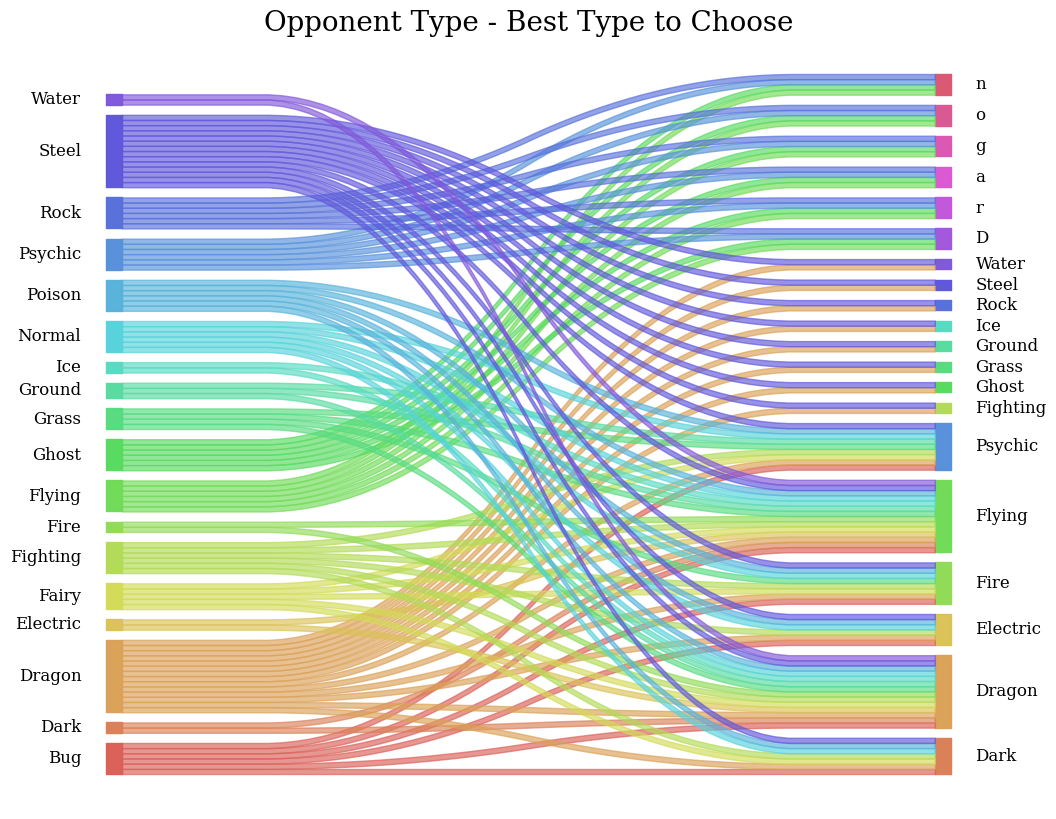

In [ ]:
sankey(predicted_df['type_opponent'], predicted_df['type_predicted_best'], fontsize=12)
plt.title('Opponent Type - Best Type to Choose', fontsize=20)
plt.gcf().set_size_inches((12, 10))
plt.show()

Continuous Data Analysis

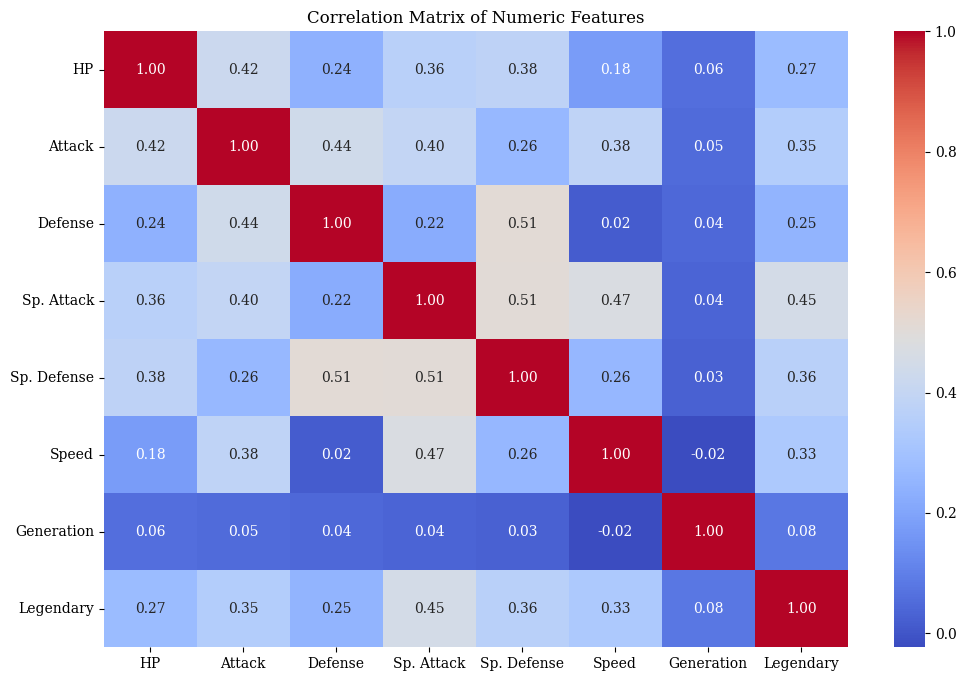

In [ ]:
'''
Correlations Among Numeric Features
Analyze correlations to understand relationships between features like HP, Attack, Defense, etc.
'''
plt.figure(figsize=(12, 8))

# Selecting the columns by name
numeric_data = df[['HP', 'Attack', 'Defense', 'Sp. Attack', 'Sp. Defense', 'Speed', 'Generation', 'Legendary']]

# Plotting the correlation matrix
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

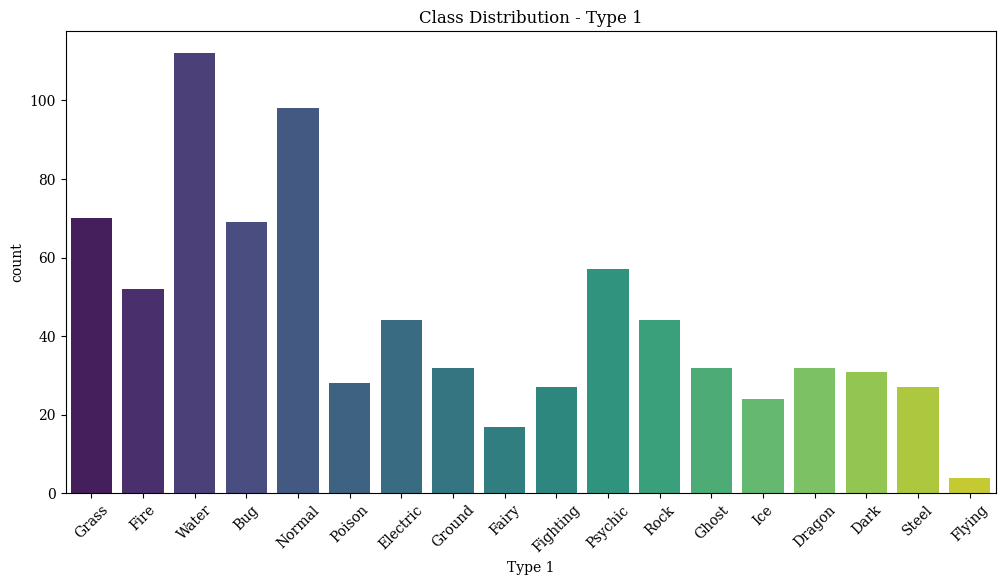

In [ ]:
# Assuming 'Type 1' is a categorical column with different Pokémon types
plt.figure(figsize=(12, 6))

# Use hue to set colors based on 'Type 1'
sns.countplot(data=df, x='Type 1', hue='Type 1', palette='viridis', legend=False)

# Title and labels
plt.title('Class Distribution - Type 1')
plt.xticks(rotation=45)

# Show the plot
plt.show()

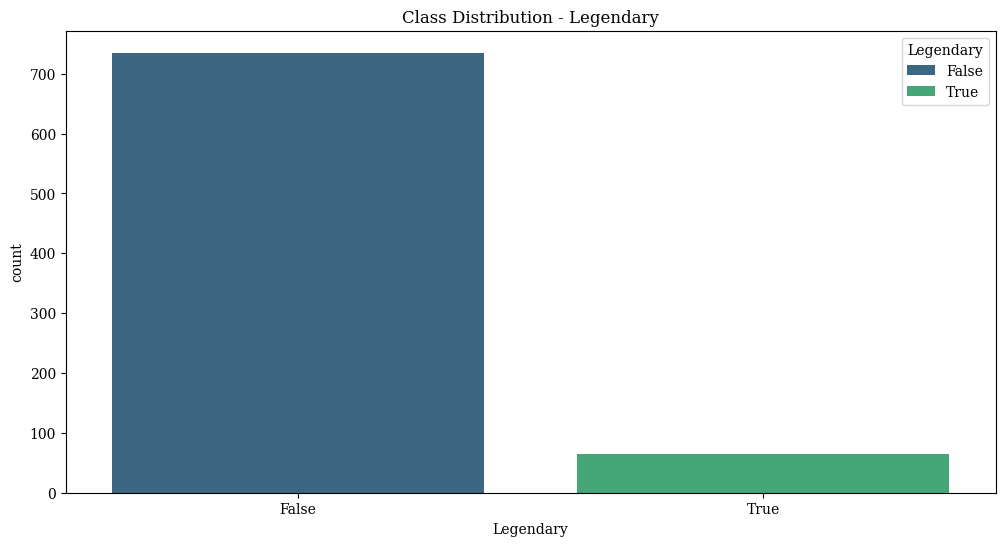

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Legendary', hue='Legendary', palette='viridis', legend=True)
plt.title('Class Distribution - Legendary')
plt.show()

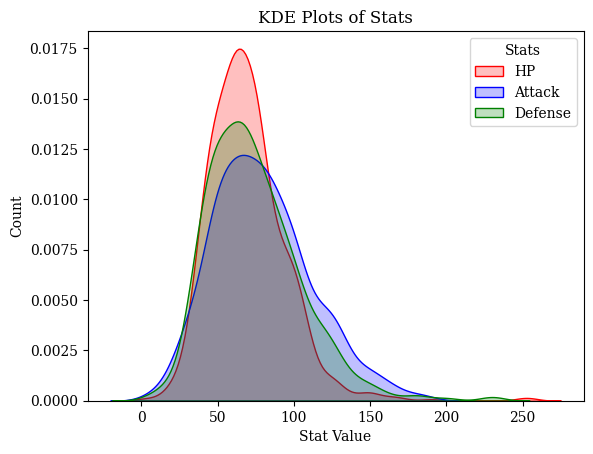

In [ ]:
# KDE plots with fill and color
sns.kdeplot(df['HP'], fill=True, color='red', label='HP')
sns.kdeplot(df['Attack'], fill=True, color='blue', label='Attack')
sns.kdeplot(df['Defense'], fill=True, color='green', label='Defense')

# Add legend
plt.legend(title='Stats', loc='upper right')
plt.title('KDE Plots of Stats')
plt.xlabel('Stat Value')
plt.ylabel('Count')

# Show the plot
plt.show()

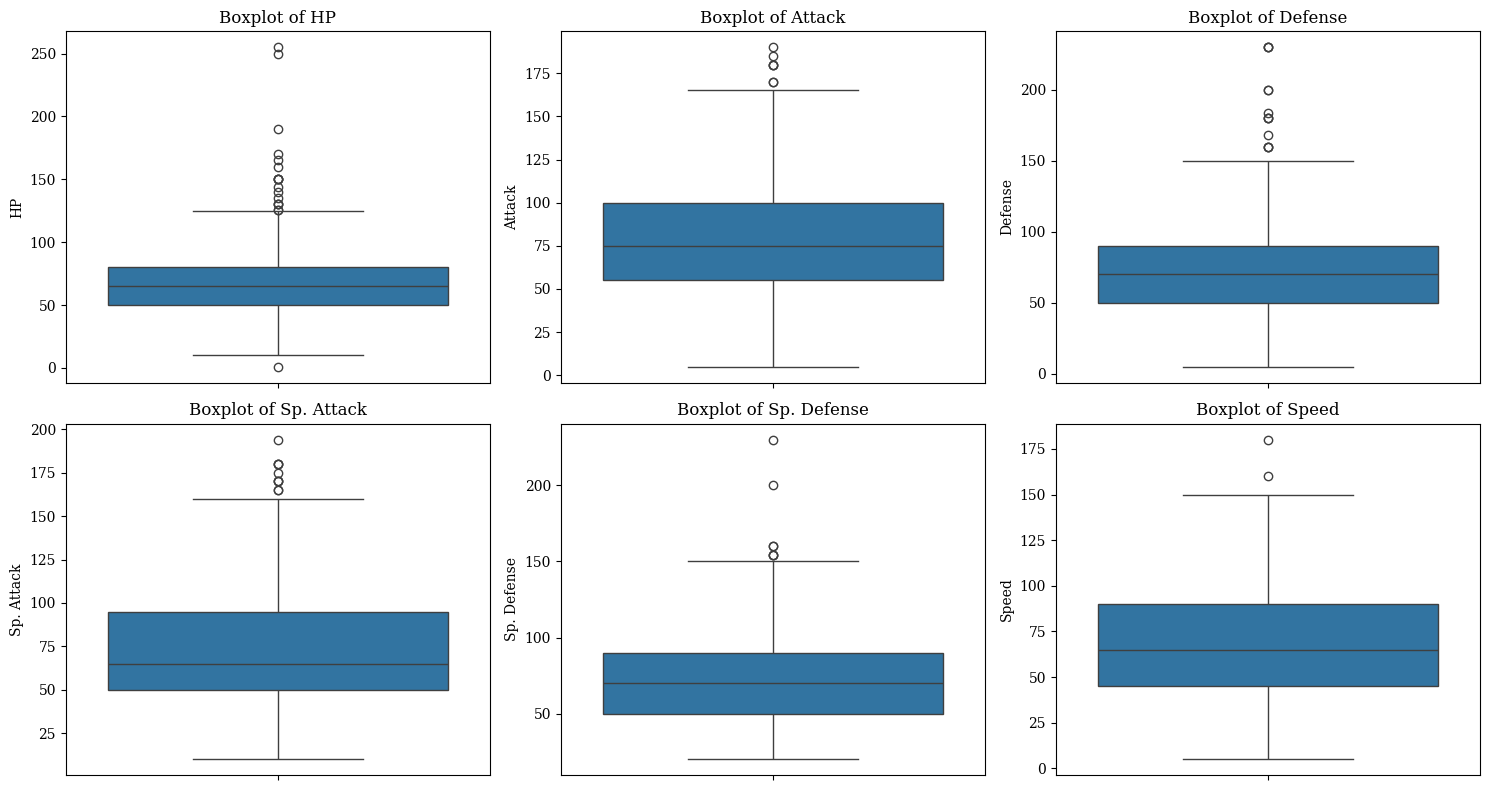

In [ ]:
'''
Checking for Outliers in Numeric Columns
Outliers can impact model performance. Using boxplots to spot potential outlier
'''
numeric_columns = ['HP', 'Attack', 'Defense', 'Sp. Attack', 'Sp. Defense', 'Speed']

plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, y=col)
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop(columns=['SN'])

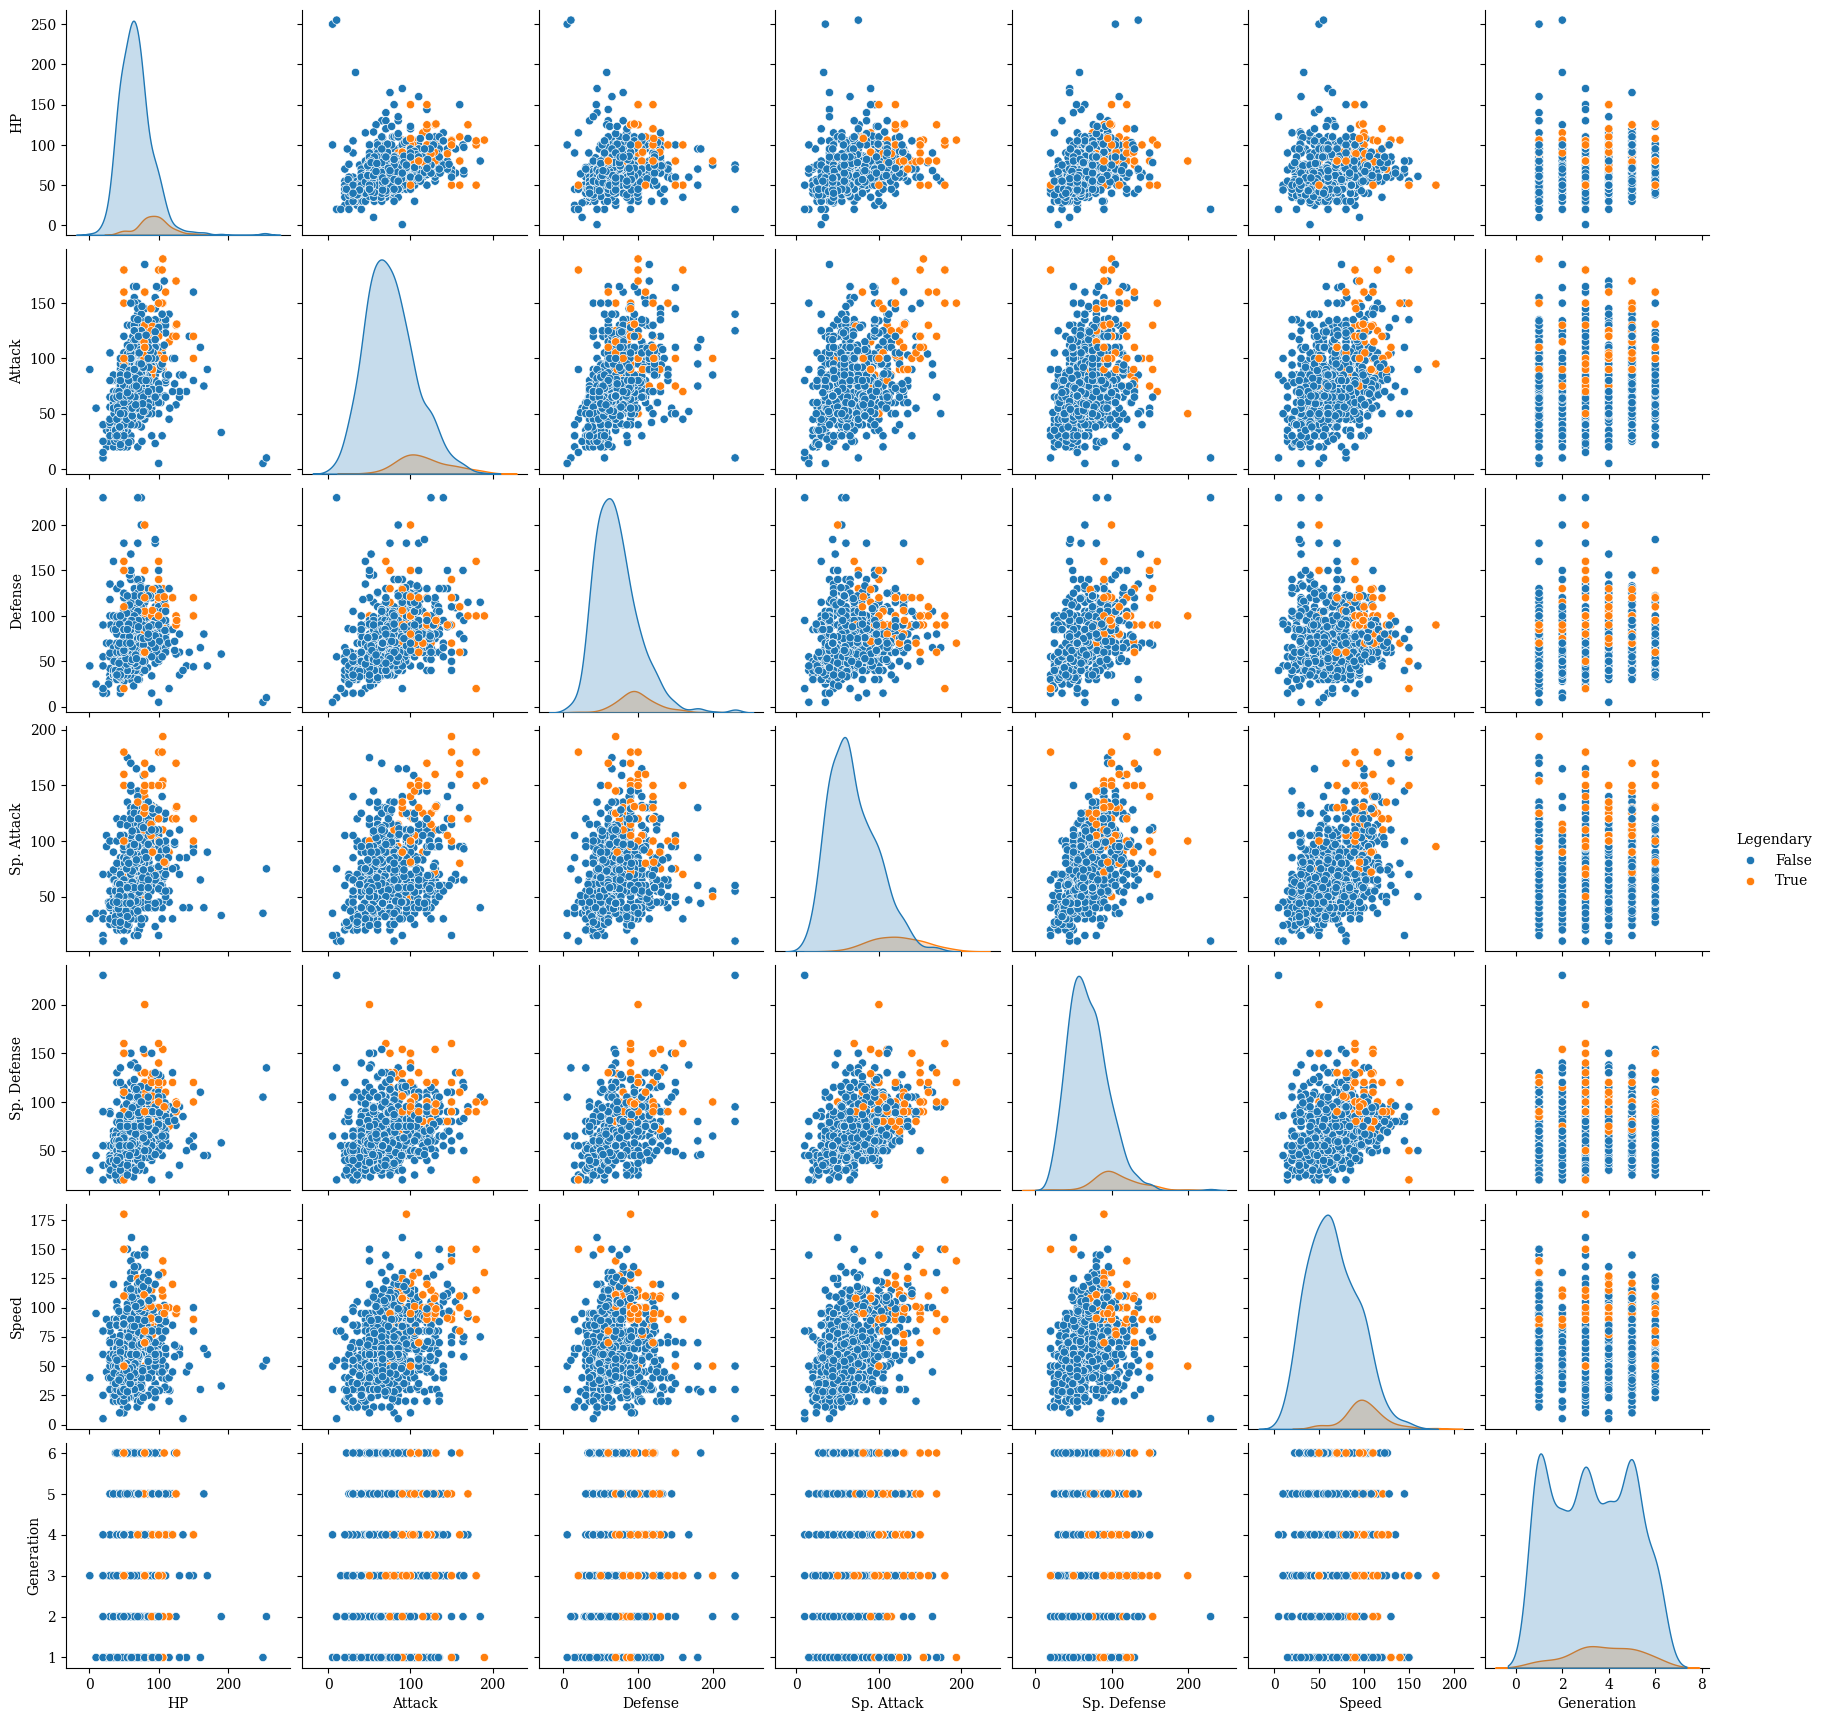

In [ ]:
sns.pairplot(df, hue='Legendary')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# K-NN

KNN Base Model

In [ ]:
# Assuming df is your DataFrame
# Select features and target variable
X = df[['Attack', 'Defense', 'Sp. Attack', 'Sp. Defense', 'Speed']]
y = df['Legendary']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (same split for all models)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# ----------- k-NN Base Model ----------- #

# Base k-NN model with fixed k = 5
k_fixed = 5
knn_base = KNeighborsClassifier(n_neighbors=k_fixed)
knn_base.fit(X_train, y_train)
y_pred_base = knn_base.predict(X_test)
accuracy_base = accuracy_score(y_test, y_pred_base)
print(f"Accuracy with fixed k={k_fixed}: {accuracy_base}")

Accuracy with fixed k=5: 0.9458333333333333


KNN Tuned Model

Optimal k: 3, Accuracy: 0.9583333333333334
Accuracy with optimal k: 0.9583333333333334


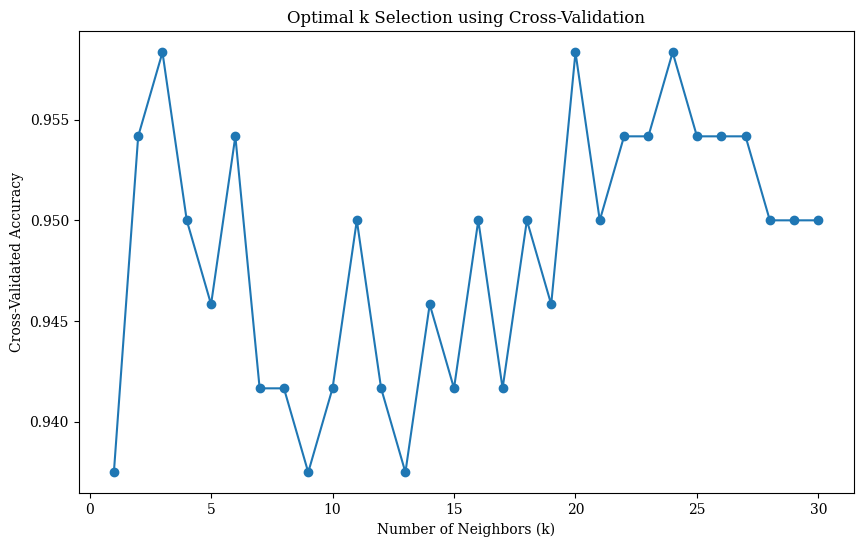

In [ ]:
# Select features and target variable
X = df[['Attack', 'Defense', 'Sp. Attack', 'Sp. Defense', 'Speed' ]]
y = df['Legendary']

# ----------- k-NN Optimal Model ----------- #

# Find the optimal k value using cross-validation
k_values = range(1, 31)  # Test k values from 1 to 30
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

optimal_k = k_values[accuracy_scores.index(max(accuracy_scores))]
print(f"Optimal k: {optimal_k}, Accuracy: {max(accuracy_scores)}")

# Train the model with the optimal k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)
y_pred_optimal = knn_optimal.predict(X_test)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
print(f"Accuracy with optimal k: {accuracy_optimal}")


# # Plot the cross-validation accuracy for each k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Optimal k Selection using Cross-Validation')
plt.show()


# Random Forest Classifier

In [ ]:
# prompt: Create 2 other eager learning classifiers as assigned based on at least 2 suitable features
# for one target variable. For each classifier, create another model with tuned
# hyperparameters that enhance the accuracy of classification.


# Base Model
# Random Forest Classifier
# Select features and target variable
X = df[['Attack', 'Defense', 'Sp. Attack', 'Sp. Defense', 'Speed']]
y = df['Legendary']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# ----------- Random Forest Classifier ----------- #

# Base Random Forest model
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_rf_base = rf_base.predict(X_test)
accuracy_rf_base = accuracy_score(y_test, y_pred_rf_base)
print(f"Base Random Forest Accuracy: {accuracy_rf_base}")


Base Random Forest Accuracy: 0.9625


In [ ]:
# Tuned Random Forest model using RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=100,
    cv=5,
    random_state=42,
    n_jobs=-1
)
rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_

y_pred_rf_improved = best_rf.predict(X_test)
accuracy_rf_improved = accuracy_score(y_test, y_pred_rf_improved)
print(f"Improved Random Forest Accuracy: {accuracy_rf_improved}")
print(f"Best parameters: {rf_random.best_params_}")

Improved Random Forest Accuracy: 0.9583333333333334
Best parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': False}


# Decision Tree Classifier

In [ ]:
# prompt:  Create Decision Tree eager learning classifiers as assigned based on at least 2 suitable features for one target variable. For each classifier, create another model with tuned
# hyperparameters that enhance the accuracy of classification.

# Decision Tree Classifier
# Select features and target variable
X = df[['Attack', 'Defense', 'Sp. Attack', 'Sp. Defense', 'Speed']]
y = df['Legendary']

# Scale features (optional but often beneficial for Decision Trees)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# ----------- Decision Tree Classifier ----------- #

# Base Decision Tree model
dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train, y_train)
y_pred_dt_base = dt_base.predict(X_test)
accuracy_dt_base = accuracy_score(y_test, y_pred_dt_base)
print(f"Base Decision Tree Accuracy: {accuracy_dt_base}")


Base Decision Tree Accuracy: 0.9583333333333334


In [ ]:
# Tuned Decision Tree model using RandomizedSearchCV
param_grid_extended = {
    'max_depth': [None, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]  # Regularization
}

dt_optimized = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_extended,
    cv=5,
    n_iter=100,  # Number of iterations
    random_state=42,
    scoring='accuracy'
)
dt_optimized.fit(X_train, y_train)

y_pred_optimized = dt_optimized.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

print(f"Optimized Decision Tree Accuracy: {accuracy_optimized}")
print(f"Best hyperparameters: {dt_optimized.best_params_}")


Optimized Decision Tree Accuracy: 0.9541666666666667
Best hyperparameters: {'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 15, 'criterion': 'log_loss', 'ccp_alpha': 0.01}


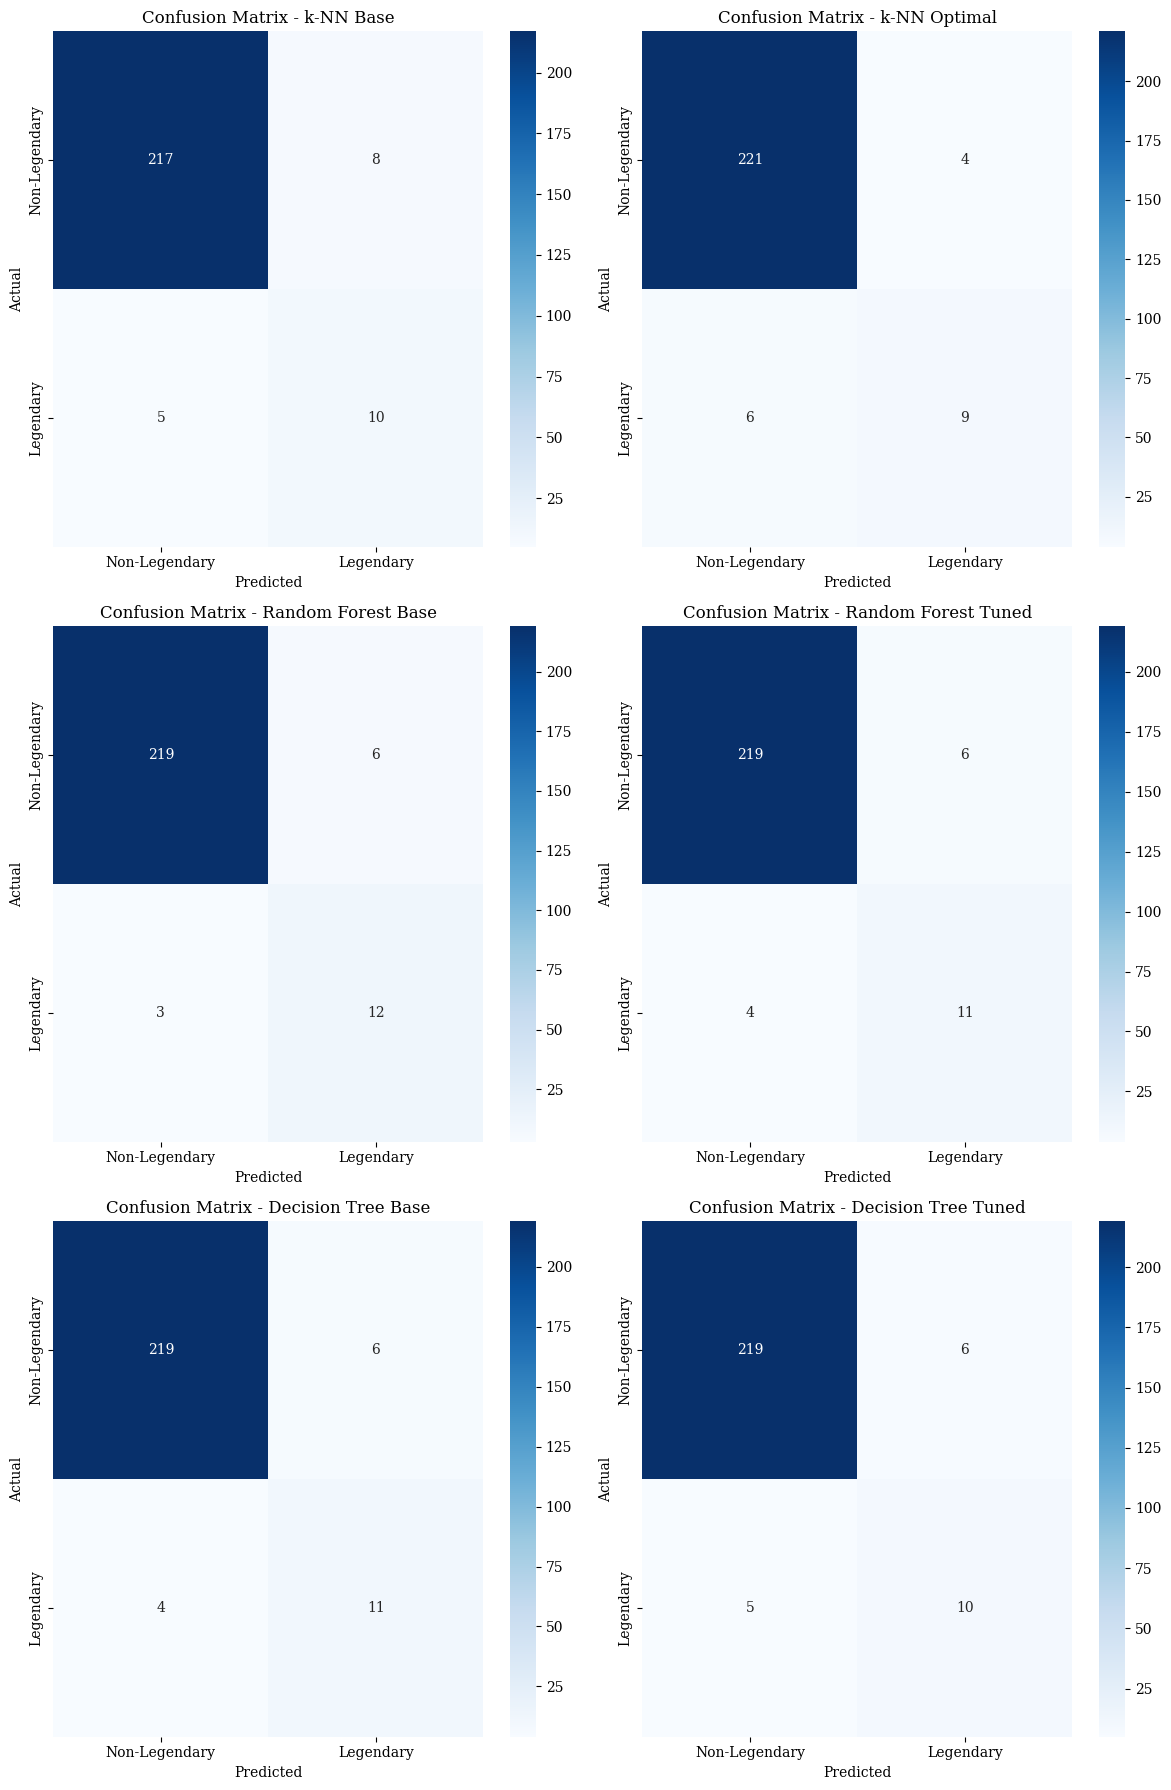

In [ ]:
# ----------- Plot Confusion Matrices for All Models ----------- #

# Ensure predictions are consistent with y_test length
predictions = [y_pred_base, y_pred_optimal, y_pred_rf_base, y_pred_rf_improved,
               y_pred_dt_base, y_pred_optimized]

# Verify that all predictions have the same length as y_test
for i, pred in enumerate(predictions):
    if len(pred) != len(y_test):
        print(f"Mismatch in length for {models[i]}: {len(pred)} vs {len(y_test)}")
        raise ValueError(f"Prediction and y_test lengths do not match for {models[i]}.")

# Models list
models = ['k-NN Base', 'k-NN Optimal', 'Random Forest Base', 'Random Forest Tuned',
          'Decision Tree Base', 'Decision Tree Tuned']

# Create subplots for a 3x2 matrix of confusion matrices
fig, axes = plt.subplots(3, 2, figsize=(12, 18))  # 3 rows and 2 columns for 6 models

# Loop through models and their corresponding predictions
for i, (model, y_pred) in enumerate(zip(models, predictions)):
    # Get the confusion matrix for the current model
    cm = confusion_matrix(y_test, y_pred)

    # Determine position of the subplot
    ax = axes[i // 2, i % 2]  # Row-wise (i//2) and column-wise (i%2)

    # Plot the confusion matrix on the corresponding subplot
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=['Non-Legendary', 'Legendary'],
                yticklabels=['Non-Legendary', 'Legendary'])

    # Set the title and labels for each subplot
    ax.set_title(f'Confusion Matrix - {model}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Adjust layout to avoid overlapping labels
plt.tight_layout()
plt.show()
